## Foreword

In this Jupyter Notebook, I'll calculate the values of $S$ and $R$ for the Eckart Barrier at a variety of particle energies ($E$). I will demonstrate the following to establish my code's legitimacy:

- $\psi^{+}$ = $(\psi^{-})^{*}$ across the entirety of my chosen grid
- $|S|^{2} + |R|^{2} = 1$ for all tested values of $E$
- Plots of $|S|^{2}$ vs. $E$ and $|R|^{2}$ vs. $E$ reproduce trends as procured from the use of [formulae for these quantities](https://drchristianphsalas.com/2020/04/23/maple-code-for-quantum-scattering-from-an-eckart-potential/#:~:text=The%20reflection%20and%20transmission%20coefficients%20for%20this%20scattering%20problem%20are%20given%20by%20the%20formulas)

## Function Definitions

First, I'll import required packages/modules and create some variables that will be used throughout my calculations.

In [1]:
import math
import cmath
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
# define some global variables (in AU) for calculations
m = 1837 # mass of a hydrogen atom in AU
V_0 = 3e-4
h_bar = 1 
a = 1 / 3

In [3]:
# establish imaginary unit
i = 1j

The function below calculates $k$/$k'$/$\kappa$ as a function of particle energy and the Eckart potential, which itself is a function of $x$ (the particle's displacement along the $x$-axis).

In [4]:
def calculate_k(E, V):
    return (2 * m * abs((E - V))) ** 0.5 / h_bar

The next function calculates the Eckart potential as a function of $x$ (the particle's displacement along the $x$-axis). Later in the notebook, I'll use it to visualize the Eckart potential being dealt with.

In [5]:
def calculate_eckart_potential(x):
    return V_0 * np.square(2 / (np.exp(a * x) + np.exp(-a * x)))

The Numerov method is carried out using the function in the following code cell.

In [6]:
def Numerov(h, k_n_plus_1, psi_n, k_n, psi_n_minus_1, k_n_minus_1):
    num = (((2 - (10 * h ** 2) / 12) * psi_n) - ((1 + (h ** 2 * k_n_minus_1 ** 2) / 12) * psi_n_minus_1))
    denom = (1 + (h ** 2 * k_n_plus_1 ** 2) / 12)
    return num / denom

The following function is where the bulk of the work is done; it calls the above functions as required to calculate $A$ and $B$ from the 2 x 2 system of linear equations in the $x\to \infty$ region, then obtains $S$ and $R$ from these coefficients (see Dr. Carrington's notes for specific details).

In [7]:
def calculate_s_and_r(E, x_0, x_n, h, plus=True):
    
    # establish a grid upon which to calculate potentials and psis
    xs = np.arange(x_0, x_n + h, h)
    Vs = calculate_eckart_potential(xs)
    ks = calculate_k(E, Vs)

    # this is for doing Numerov on psi_plus
    if plus:
        # calculate initial psi_n_minus_1
        psi_n_minus_1 = cmath.exp(i * ks[0] * xs[0])
        # calculate initial psi_n
        psi_n = cmath.exp(i * ks[1] * xs[1])
        
    # this is for doing Numerov on psi_minus
    else:
        # calculate initial psi_n_minus_1
        psi_n_minus_1 = cmath.exp(-i * ks[0] * xs[0])
        # calculate initial psi_n
        psi_n = cmath.exp(-i * ks[1] * xs[1])
    
    # this list will house all psis calculated from Numerov
    all_psis = [psi_n_minus_1, psi_n]
    
    # do numerov to get rest of psis
    for n in list(range(xs.shape[0]))[2:]:
        psi_n_temp = psi_n
        psi_n = Numerov(h, ks[n], psi_n, ks[n - 1], psi_n_minus_1, ks[n - 2])
        all_psis.append(psi_n)
        psi_n_minus_1 = psi_n_temp
    
    if plus:
        psi_pluses = np.array(all_psis)
        psi_minuses = np.conjugate(psi_pluses)
    else:
        psi_minuses = np.array(all_psis)
        psi_pluses = np.conjugate(psi_minuses)
        
    # work near limit as x goes to infinity (i.e., select last two psis from psi_pluses)
    # solve for A and B coefficients by solving Ax = b 2x2 system of linear equations
    A_matrix = np.array([[cmath.exp(i * ks[-2] * xs[-2]), cmath.exp(-i * ks[-2] * xs[-2])], 
                         [cmath.exp(i * ks[-1] * xs[-1]), cmath.exp(-i * ks[-1] * xs[-1])]])
    b_vector = np.array([psi_pluses[-2], psi_pluses[-1]])
    x_vector = np.matmul(np.linalg.inv(A_matrix), b_vector)
    
    A = x_vector[0]
    B = x_vector[1]

    s = (A - (abs(B) ** 2) / A.conjugate())
    r = -B / A.conjugate()
    
    return s, r, psi_pluses, psi_minuses

These last two functions employ the formulae for $|S|^{2}$ and $|R|^{2}$ as [defined at this link.](https://drchristianphsalas.com/2020/04/23/maple-code-for-quantum-scattering-from-an-eckart-potential/#:~:text=The%20reflection%20and%20transmission%20coefficients%20for%20this%20scattering%20problem%20are%20given%20by%20the%20formulas)

In [8]:
def calculate_s(k):
    
    num = np.square(np.sinh(math.pi * k * a))
    denom = np.square(np.sinh(math.pi * k * a)) + np.square(np.cosh((math.pi / 2) * (abs(1 - ((8 * m * V_0 * a ** 2) / (h_bar ** 2)))) ** 0.5))
    return num / denom

def calculate_r(k):
    
    num = np.square(np.cosh((math.pi / 2) * (abs(1 - ((8 * m * V_0 * a ** 2) / (h_bar ** 2)))) ** 0.5))
    denom = np.square(np.sinh(math.pi * k * a)) + np.square(np.cosh((math.pi / 2) * (abs(1 - ((8 * m * V_0 * a ** 2) / (h_bar ** 2)))) ** 0.5))
    return num / denom

## Plot the Eckart Barrier Across Chosen Grid

For the Numerov method, we must define a grid of points upon which to carry out our evaluations. The grid that I have chosen for this notebook goes from $x_{0} = -10,000$ to $x_{n} = 10,000$ with a step size of $h = 0.1$. I haven't fine-tuned these parameters too much, so perhaps they are not the most efficient choices, but at least they produce the expected results. Before calculating $S$ and $R$, it is worth plotting the Eckart Barrier based on my grid of points:

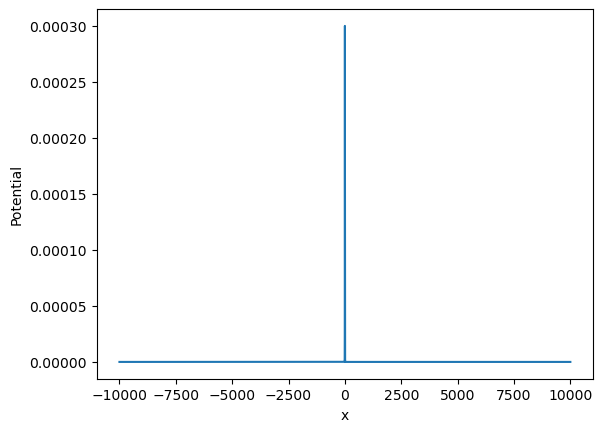

In [9]:
# plot Eckart potential for given grid
x_0 = -10000
x_n = 10000
h = 0.1
xs = np.arange(x_0, x_n + h, h)
Vs = calculate_eckart_potential(xs)
plt.xlabel("x")
plt.ylabel("Potential")
plt.plot(xs, Vs)

## Do My Calculations Make Sense?

I'll try to answer this question by demonstrating that $|S|^{2} + |R|^{2} = 1$ for all tested values of $E$ and $\psi^{+}$ = $(\psi^{-})^{*}$ across my chosen grid. Below, I'll print the following:

- The 100 values of particle energy at which I calculated $S$ and $R$
- The values of $|S|^{2} + |R|^{2}$ for each of the 100 particle energies that I used
    - Notice how every value in this array is 1
- The first 100 values of $\psi^{+}$ and $\psi^{-}$ *for the last value of particle energy that I tested*
    - The reason I show only this subset is because there are about 200,000 values each of $\psi^{+}$ and $\psi^{-}$ for each tested particle energy (one per grid point), which is far too many to print
    - If you look closely, you'll see that $\psi^{+}$ and $\psi^{-}$ are the same except for being opposite in sign for their imaginary components (i.e., $\psi^{+}$ = $(\psi^{-})^{*}$)

In [10]:
energies = np.logspace(-10, -3, 100)
S = []
R = []

for E in energies:
    s, r, psi_pluses, psi_minuses = calculate_s_and_r(E, x_0, x_n, h)
#     print("E =", E)
#     print("S^2 =", abs(s) ** 2)
    S.append(abs(s) ** 2)
#     print("R^2 =", abs(r) ** 2)
    R.append(abs(r) ** 2)


In [11]:
print("Tested particle energies:")
print()
print(energies)
print()
print()
print()
print("|S|^2 + |R|^2 at each particle energy:")
print()
print(np.array(S) + np.array(R))
print()
print()
print()
print("ψ^+:")
print(psi_pluses[:99])
print()
print()
print()
print("ψ^-:")
print(psi_minuses[:99])

Tested particle energies:

[1.00000000e-10 1.17681195e-10 1.38488637e-10 1.62975083e-10
 1.91791026e-10 2.25701972e-10 2.65608778e-10 3.12571585e-10
 3.67837977e-10 4.32876128e-10 5.09413801e-10 5.99484250e-10
 7.05480231e-10 8.30217568e-10 9.77009957e-10 1.14975700e-09
 1.35304777e-09 1.59228279e-09 1.87381742e-09 2.20513074e-09
 2.59502421e-09 3.05385551e-09 3.59381366e-09 4.22924287e-09
 4.97702356e-09 5.85702082e-09 6.89261210e-09 8.11130831e-09
 9.54548457e-09 1.12332403e-08 1.32194115e-08 1.55567614e-08
 1.83073828e-08 2.15443469e-08 2.53536449e-08 2.98364724e-08
 3.51119173e-08 4.13201240e-08 4.86260158e-08 5.72236766e-08
 6.73415066e-08 7.92482898e-08 9.32603347e-08 1.09749877e-07
 1.29154967e-07 1.51991108e-07 1.78864953e-07 2.10490414e-07
 2.47707636e-07 2.91505306e-07 3.43046929e-07 4.03701726e-07
 4.75081016e-07 5.59081018e-07 6.57933225e-07 7.74263683e-07
 9.11162756e-07 1.07226722e-06 1.26185688e-06 1.48496826e-06
 1.74752840e-06 2.05651231e-06 2.42012826e-06 2.84803587e-

In [12]:
S_expected_lst = []
R_expected_lst = []

expected_energies = np.logspace(-10, -2, 100)

xs = np.arange(x_0, x_n + h, h)
Vs = calculate_eckart_potential(xs)
ks = calculate_k(expected_energies, 0)

for k in ks:
    S_expected = calculate_s(k)
    S_expected_lst.append(abs(S_expected) ** 2)
    R_expected = calculate_r(k)
    R_expected_lst.append(abs(R_expected) ** 2)

## Comparing My Results to Analytical Expressions Graphically

As the last part of this assignment, I'll make plots of $|S|^{2}$ vs. $E$ and $|R|^{2}$ vs. $E$ for both my code and what is expected from the formulae. Qualitatively, both my code and the formulae give very similar results, which are intuitive; as particle energy increases, the probability of transmission through the barrier increases ($|S|^{2}$ gets closer to 1); conversely, as particle energy decreases, the probability of reflection off the barrier increases ($|R|^{2}$ gets closer to 1).

### $|S|^{2}$ v.s. $E$ Using My Code

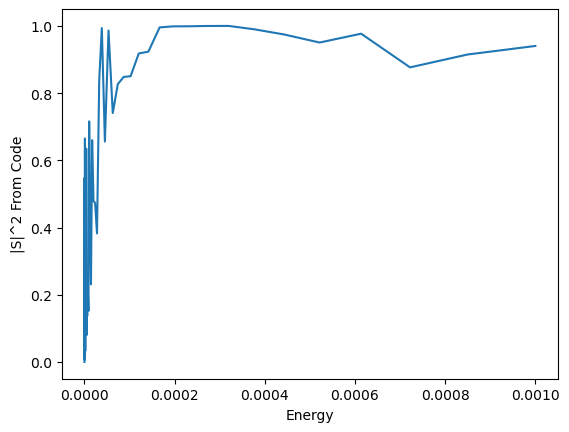

In [13]:
plt.xlabel("Energy")
plt.ylabel("|S|^2 From Code")
plt.plot(energies, S)

### $|S|^{2}$ v.s. $E$ Using Formula

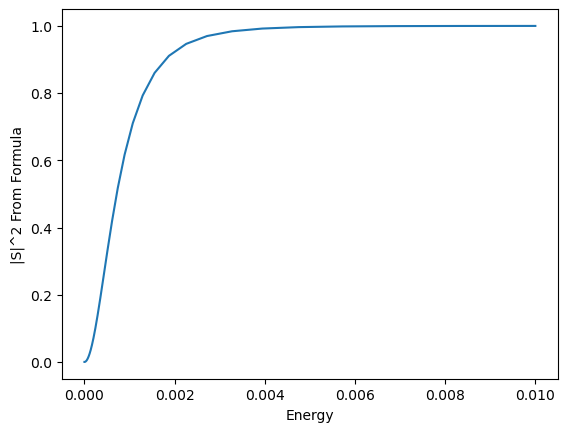

In [14]:
plt.xlabel("Energy")
plt.ylabel("|S|^2 From Formula")
plt.plot(expected_energies, S_expected_lst)

### $|R|^{2}$ v.s. $E$ Using My Code

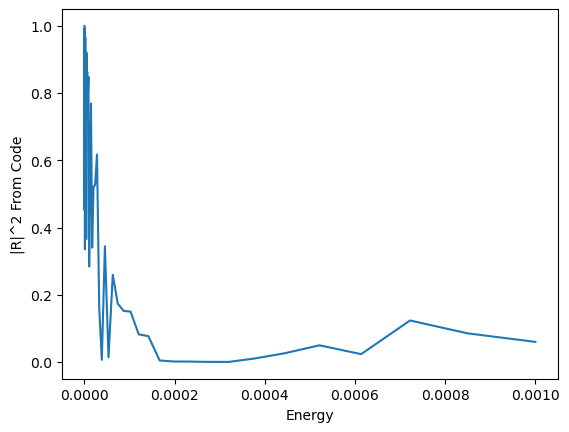

In [15]:
plt.xlabel("Energy")
plt.ylabel("|R|^2 From Code")
plt.plot(energies, R)

### $|R|^{2}$ v.s. $E$ Using Formula

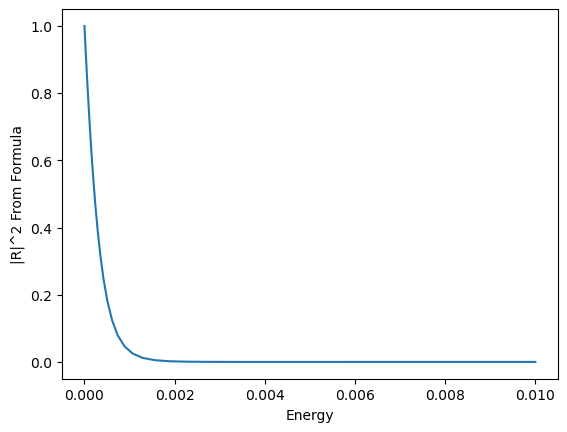

In [16]:
plt.xlabel("Energy")
plt.ylabel("|R|^2 From Formula")
plt.plot(expected_energies, R_expected_lst)